# Import Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re
import spacy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


# Download Spacy English Model

In [2]:
nlp = spacy.load("en_core_web_sm", disable = ["parser", "ner", "textcat", "tagger"])

# Read Data

In [3]:
train = pd.read_csv("../input/cite-dataset/tsv/train.tsv", sep= '\t',names=["id", "explicit", "text", "label"])
dev = pd.read_csv("../input/cite-dataset/tsv/dev.tsv", sep= '\t', names=["id", "explicit", "text", "label"])
test = pd.read_csv("../input/cite-dataset/tsv/test.tsv", sep= '\t', names=["id", "explicit", "text", "label"])

# Drop Columns Not Used

In [4]:
train.drop(['id', 'explicit'], axis = 1, inplace = True)
test.drop(['id', 'explicit'], axis = 1, inplace = True)

# Convert String Label to Numeric Label

In [5]:
label_to_num = {"background":0, "method":1, "result":2}
def label_decoder(label):
    return label_to_num[label]

In [6]:
train["label1"] = train["label"].apply(lambda x: label_decoder(x))
train.head()

,text,label,label1
0,"However, how frataxin interacts with the Fe-S ...",background,0
1,"In the study by Hickey et al. (2012), spikes w...",background,0
2,"The drug also reduces catecholamine secretion,...",background,0
3,By clustering with lowly aggressive close kin ...,background,0
4,Ophthalmic symptoms are rare manifestations of...,background,0


In [7]:
test["label1"] = test["label"].apply(lambda x: label_decoder(x))
test.head()

,text,label,label1
0,"Chapel, as well as X10 [2], UPC [3] , CoArray ...",background,0
1,"In addition, the result of the present study s...",result,2
2,Several instruments that more specifically add...,background,0
3,Organotypic hippocampal slice cultures\nInterf...,method,1
4,Activated PBMC are the basis of the standard P...,background,0


# Preprocess Data

In [8]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english') # Snowball Stemmer is used to get stemmed form of word

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [9]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [10]:
train["text1"] = train["text"].apply(lambda x: preprocess(x))
test["text1"] = test["text"].apply(lambda x: preprocess(x))

# Tokenize Sentences

In [11]:
tokens = []
for doc in tqdm(nlp.pipe(train["text1"].values, n_threads = 16)):
    tokens.append(" ".join([n.text for n in doc]))
train["text1"] = tokens

8243it [00:03, 2074.81it/s]


In [12]:
tokens = []
for doc in tqdm(nlp.pipe(test["text1"].values, n_threads = 16)):
    tokens.append(" ".join([n.text for n in doc]))
test["text1"] = tokens

1861it [00:00, 2548.86it/s]


# Generate POS Tags for Words in the Sentence

In [13]:
nlp = spacy.load('en', disable = ["parser", "ner", "textcat"])
tokens = []
for doc in tqdm(nlp.pipe(train["text1"].values, n_threads = 16)):
    tokens.append(" ".join([n.text + "_"  + n.pos_ for n in doc]))
train["text1"] = tokens

8243it [00:13, 632.01it/s]


In [14]:
nlp = spacy.load('en', disable = ["parser", "ner", "textcat"])
tokens = []
for doc in tqdm(nlp.pipe(test["text1"].values, n_threads = 16)):
    tokens.append(" ".join([n.text + "_"  + n.pos_ for n in doc]))
test["text1"] = tokens

1861it [00:03, 517.66it/s]


# Convert POS Tags to Lower Case

Conversion is needed otherwise tokenizer does not work on the sentences.

In [15]:
train["text1"] = train["text1"].str.lower()
test["text1"] = test["text1"].str.lower()

# Split Data for Validation

In [16]:
train, val = train_test_split(train, test_size=0.2, random_state=2018)

# Tokenize Sentences

In [17]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\]^`{|}~')

tokenizer.fit_on_texts(train.text1)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 32252


# Length of Largest Sentence

In [18]:
MAX_SEQUENCE_LENGTH = 100

# Pad Sentences to Length of Largest Sentence

In [19]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train.text1),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_val = pad_sequences(tokenizer.texts_to_sequences(val.text1),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test.text1),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Validation X Shape:",x_val.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (6594, 100)
Validation X Shape: (1649, 100)
Testing X Shape: (1861, 100)


# Vectorize the Labels

In [20]:
y_train = train['label1']
y_val = val["label1"]
y_test = test['label1']

In [21]:
y_train_list = []
for i in y_train:
    kd = np.zeros(3)
    kd[i]=1
    y_train_list.append(list(kd))

In [22]:
y_val_list = []
for i in y_val:
    kd = np.zeros(3)
    kd[i]=1
    y_val_list.append(list(kd))

In [23]:
y_test_list = []
for i in y_test:
    kd = np.zeros(3)
    kd[i]=1
    y_test_list.append(list(kd))

In [24]:
y_train_list = np.array(y_train_list)
y_val_list = np.array(y_val_list)
y_test_list = np.array(y_test_list)

# Download GloVE Model

In [25]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-07-31 18:25:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-31 18:25:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-31 18:25:22--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

# Conguration Values

In [26]:
GLOVE_EMB = '/kaggle/working/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 50
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

# Load GloVe Model

In [27]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


# Generate Embedding Matrix from GloVe Model

In [28]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = vocab_size

vocab_dict = {}
embedding_matrix = np.random.normal(emb_mean, emb_std, (vocab_size, embed_size))
for word, i in word_index.items():
    if i >= nb_words: continue
    word_part = word.split("_")[0]
    embedding_vector = embeddings_index.get(word_part)
    if embedding_vector is not None: 
        if word_part in vocab_dict:
            vocab_dict[word_part].append((word, i))
        else:
            vocab_dict[word_part] = [(word, i)]
        embedding_matrix[i] = embedding_vector

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


# Embedding Layer to Vectorize Padded Sequences using Embedding Matrix

In [29]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# LSTM Model

In [30]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2))(x)
outputs = Dense(3, activation='softmax')(x)
model = tf.keras.Model(sequence_input, outputs)

# Early Stopping Callback

In [31]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20, # Wait for next best value till 20 epochs
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# Model Checkpointing Callback

In [32]:
mc = tf.keras.callbacks.ModelCheckpoint(
    "./model{epoch:04d}.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
)

# Compile Model

In [33]:
model.compile(optimizer=Adam(learning_rate=LR), loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train Model

In [34]:
history = model.fit(x_train, y_train_list, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_val, y_val_list), callbacks=[es, mc])

Train on 6594 samples, validate on 1649 samples
Epoch 1/50
6144/6594 [==========================>...] - ETA: 0s - loss: 1.0011 - accuracy: 0.5464
Epoch 00001: val_loss improved from inf to 0.94488, saving model to ./model0001.h5
6594/6594 [==============================] - 9s 1ms/sample - loss: 0.9989 - accuracy: 0.5491 - val_loss: 0.9449 - val_accuracy: 0.5719
Epoch 2/50
6144/6594 [==========================>...] - ETA: 0s - loss: 0.9045 - accuracy: 0.6016
Epoch 00002: val_loss improved from 0.94488 to 0.89586, saving model to ./model0002.h5
6594/6594 [==============================] - 3s 383us/sample - loss: 0.9042 - accuracy: 0.6024 - val_loss: 0.8959 - val_accuracy: 0.5901
Epoch 3/50
6144/6594 [==========================>...] - ETA: 0s - loss: 0.8575 - accuracy: 0.6302
Epoch 00003: val_loss improved from 0.89586 to 0.82539, saving model to ./model0003.h5
6594/6594 [==============================] - 3s 392us/sample - loss: 0.8533 - accuracy: 0.6310 - val_loss: 0.8254 - val_accuracy:

# Plot of the Training and Validation Metrics

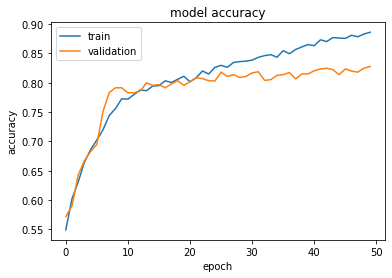

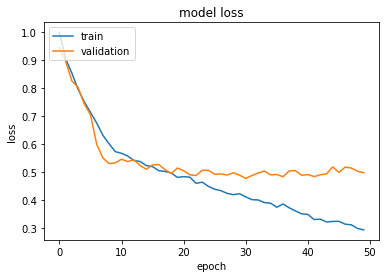

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Test Data Evaluation

In [36]:
test_acc = model.evaluate(x_test, y_test_list, verbose=1)
print("Test Loss:", test_acc[0])
print("Test Accuracy:", test_acc[1])

1861/1861 [==============================] - 3s 1ms/sample - loss: 0.6224 - accuracy: 0.7834
Test Loss: 0.622403577258355
Test Accuracy: 0.78344977


In [37]:
y_pred = model.predict(x_test, verbose=0)
yhat = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test_list,axis = 1)

In [38]:
accuracy_score(y_true,yhat)

0.7834497581945191

In [39]:
precision_score(y_true,yhat, average='macro')

0.7535799330769279

In [40]:
recall_score(y_true,yhat, average='macro')

0.7802855517636224

In [41]:
f1_score(y_true,yhat, average='macro')

0.7646448013420489